<a href="https://colab.research.google.com/github/Blockchain-Framework/bitcoin-anomaly-analysis/blob/develop/Notebooks/cnn/1d_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, datasets, layers, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, AveragePooling2D, LayerNormalization

### Splitting Data


In [9]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [11]:
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [ ]:
# y_train.head()

521773      4.0
323487      1.0
1081637    11.0
257266      1.0
381983      1.0
Name: Cat, dtype: float64

In [84]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/Anomaly/bitcoin_imbalance_train_set.csv')
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FYP/Anomaly/bitcoin_imbalance_test.csv")

In [85]:
# Split train dataset
X_train = train.drop(columns=['label'])  # Drop the 'label' column for features
y_train = train['label']  # Select the 'label' column for the target variable

# Split test dataset
X_test = test.drop(columns=['label'])  # Drop the 'label' column for features
y_test = test['label']  # Select the 'label' column for the target variable

In [87]:
# Convert multi-class to binary classification for the target variable
y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test = y_test.apply(lambda x: 1 if x > 0 else 0)

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

### Features Extraction

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

forest = RandomForestClassifier()
_ = forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))

In [21]:
rfe = RFE(forest, n_features_to_select=20)

# Define 5-fold cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Perform RFE with 5-fold cross-validation
scores = cross_val_score(rfe, X_train, y_train, cv=cv)

# Print mean score and standard deviation
print('Accuracy: {:.3f} (+/- {:.3f})'.format(scores.mean(), scores.std()))

Accuracy: 0.677 (+/- 0.004)


In [22]:
pd.DataFrame(
    zip(X_train.columns, abs(forest.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight").reset_index(drop=True)

,feature,weight
0,output_time_diff_minimum,0.000000
1,input_time_diff_minimum,0.000000
2,input_output_max_ratio,0.000051
3,input_output_maximum_transaction_value_diff,0.000064
4,input_output_minimum_transaction_value_diff,0.000224
...,...,...
57,output_value_usd_minimum,0.029758
58,input_spending_value_usd_25th_percentile,0.029892
59,output_value_usd_75th_percentile,0.030951
60,output_value_usd_25th_percentile,0.033325


In [25]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
# Init, fit
# scoring = ['accuracy', 'precision', 'recall', 'f1']
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    min_features_to_select=20,
    n_jobs=-1,
    step=10,
    scoring='f1_macro',
    cv=5
)

In [26]:
_ = rfecv.fit(X_train, y_train)

In [27]:
print(X_train.columns[rfecv.get_support()])

Index(['input_transaction_count', 'output_transaction_count',
       'input_value_mean', 'input_value_median', 'input_value_maximum',
       'input_value_minimum', 'input_value_25th_percentile',
       'input_value_75th_percentile', 'input_value_range',
       'input_spending_value_usd_mean', 'input_spending_value_usd_median',
       'input_spending_value_usd_maximum', 'input_spending_value_usd_minimum',
       'input_spending_value_usd_25th_percentile',
       'input_spending_value_usd_75th_percentile',
       'input_spending_value_usd_range', 'input_time_diff_mean',
       'input_time_diff_median', 'input_time_diff_maximum',
       'input_time_diff_25th_percentile', 'input_time_diff_75th_percentile',
       'input_time_diff_range', 'output_value_usd_mean',
       'output_value_usd_median', 'output_value_usd_maximum',
       'output_value_usd_minimum', 'output_value_usd_25th_percentile',
       'output_value_usd_75th_percentile', 'output_value_usd_range',
       'output_time_diff_mean

In [28]:
selected_features = X_train.columns[rfecv.get_support()]
# selected_features=selected_features.tolist()

In [29]:
selected_features

Index(['input_transaction_count', 'output_transaction_count',
       'input_value_mean', 'input_value_median', 'input_value_maximum',
       'input_value_minimum', 'input_value_25th_percentile',
       'input_value_75th_percentile', 'input_value_range',
       'input_spending_value_usd_mean', 'input_spending_value_usd_median',
       'input_spending_value_usd_maximum', 'input_spending_value_usd_minimum',
       'input_spending_value_usd_25th_percentile',
       'input_spending_value_usd_75th_percentile',
       'input_spending_value_usd_range', 'input_time_diff_mean',
       'input_time_diff_median', 'input_time_diff_maximum',
       'input_time_diff_25th_percentile', 'input_time_diff_75th_percentile',
       'input_time_diff_range', 'output_value_usd_mean',
       'output_value_usd_median', 'output_value_usd_maximum',
       'output_value_usd_minimum', 'output_value_usd_25th_percentile',
       'output_value_usd_75th_percentile', 'output_value_usd_range',
       'output_time_diff_mean

In [30]:
n=20
feature_importance = _.estimator_.feature_importances_  # or coef_
feature_importance_sorted = sorted(enumerate(feature_importance), key=lambda x: x[1])
top_n_idx = [idx for idx, _ in feature_importance_sorted[:n]]

top_64_features = X_train.columns[top_n_idx]
top_64_features = top_64_features.tolist()
top_64_features

['output_value_75th_percentile',
 'input_value_range',
 'output_value_25th_percentile',
 'output_time_diff_maximum',
 'output_transaction_count',
 'input_spending_value_usd_range',
 'range_mean_ratio_input',
 'input_transaction_count',
 'output_time_diff_mean',
 'output_value_usd_75th_percentile',
 'output_value_range',
 'input_time_diff_75th_percentile',
 'range_mean_ratio_output',
 'output_time_diff_25th_percentile',
 'output_value_usd_range',
 'input_time_diff_maximum',
 'output_time_diff_minimum',
 'output_time_diff_median',
 'input_output_usd_mean_ratio',
 'input_time_diff_mean']

In [31]:
features_removed=(set(X_train.columns)-set(top_64_features))
features_removed

{'input_output_max_ratio',
 'input_output_maximum_transaction_value_diff',
 'input_output_mean_ratio',
 'input_output_min_ratio',
 'input_output_minimum_transaction_value_diff',
 'input_output_percentile_25_diff',
 'input_output_percentile_75_diff',
 'input_output_time_diff_max_min_diff',
 'input_output_transaction_count_ratio',
 'input_output_usd_max_ratio',
 'input_output_usd_min_ratio',
 'input_output_usd_percentile_25_diff',
 'input_output_usd_percentile_75_diff',
 'input_range_mean_ratio',
 'input_spending_value_usd_25th_percentile',
 'input_spending_value_usd_75th_percentile',
 'input_spending_value_usd_maximum',
 'input_spending_value_usd_mean',
 'input_spending_value_usd_median',
 'input_spending_value_usd_minimum',
 'input_time_diff_25th_percentile',
 'input_time_diff_median',
 'input_time_diff_minimum',
 'input_time_diff_range',
 'input_value_25th_percentile',
 'input_value_75th_percentile',
 'input_value_maximum',
 'input_value_mean',
 'input_value_median',
 'input_value_min

In [90]:
features_to_be_dropped=['input_output_max_ratio',
 'input_output_maximum_transaction_value_diff',
 'input_output_mean_ratio',
 'input_output_min_ratio',
 'input_output_minimum_transaction_value_diff',
 'input_output_percentile_25_diff',
 'input_output_percentile_75_diff',
 'input_output_time_diff_max_min_diff',
 'input_output_transaction_count_ratio',
 'input_output_usd_max_ratio',
 'input_output_usd_min_ratio',
 'input_output_usd_percentile_25_diff',
 'input_output_usd_percentile_75_diff',
 'input_range_mean_ratio',
 'input_spending_value_usd_25th_percentile',
 'input_spending_value_usd_75th_percentile',
 'input_spending_value_usd_maximum',
 'input_spending_value_usd_mean',
 'input_spending_value_usd_median',
 'input_spending_value_usd_minimum',
 'input_time_diff_25th_percentile',
 'input_time_diff_median',
 'input_time_diff_minimum',
 'input_time_diff_range',
 'input_value_25th_percentile',
 'input_value_75th_percentile',
 'input_value_maximum',
 'input_value_mean',
 'input_value_median',
 'input_value_minimum',
 'output_range_mean_ratio',
 'output_time_diff_75th_percentile',
 'output_time_diff_range',
 'output_value_maximum',
 'output_value_mean',
 'output_value_median',
 'output_value_minimum',
 'output_value_usd_25th_percentile',
 'output_value_usd_maximum',
 'output_value_usd_mean',
 'output_value_usd_median',
 'output_value_usd_minimum']

In [91]:
X_train=X_train.drop(features_to_be_dropped, axis=1)
X_test=X_test.drop(features_to_be_dropped, axis=1)
X_val=X_val.drop(features_to_be_dropped, axis=1)

## Model Training

### Multiclass Classification

In [105]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LayerNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=(20, 1)))
model.add(LayerNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.05))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model.add(LayerNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.05))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
model.add(LayerNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.05))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'))
model.add(LayerNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.05))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)

X_val = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# X_train = np.reshape(X_train, (X_train.shape[0], 20))

In [97]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(54606, 20, 1)
(17800, 20, 1)
(18203, 20, 1)


In [106]:
from keras.callbacks import EarlyStopping
print(X_train.shape)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

(54606, 20, 1)
Epoch 1/50
1707/1707 [==============================] - 55s 31ms/step - loss: 0.6128 - accuracy: 0.6212 - val_loss: 0.5855 - val_accuracy: 0.6489
Epoch 2/50
1707/1707 [==============================] - 49s 29ms/step - loss: 0.5934 - accuracy: 0.6356 - val_loss: 0.5832 - val_accuracy: 0.6587
Epoch 3/50
1707/1707 [==============================] - 52s 30ms/step - loss: 0.5823 - accuracy: 0.6563 - val_loss: 0.5782 - val_accuracy: 0.6726
Epoch 4/50
1707/1707 [==============================] - 50s 29ms/step - loss: 0.5707 - accuracy: 0.6747 - val_loss: 0.5575 - val_accuracy: 0.6925
Epoch 5/50
1707/1707 [==============================] - 50s 29ms/step - loss: 0.5643 - accuracy: 0.6826 - val_loss: 0.5502 - val_accuracy: 0.6991
Epoch 6/50
1707/1707 [==============================] - 47s 27ms/step - loss: 0.5594 - accuracy: 0.6882 - val_loss: 0.5461 - val_accuracy: 0.7013
Epoch 7/50
1707/1707 [==============================] - 49s 29ms/step - loss: 0.5561 - accuracy: 0.6911 - val

In [107]:
model.save('/content/drive/MyDrive/Colab Notebooks/FYP/Anomaly/1d_CNN/CNN1D_binary.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


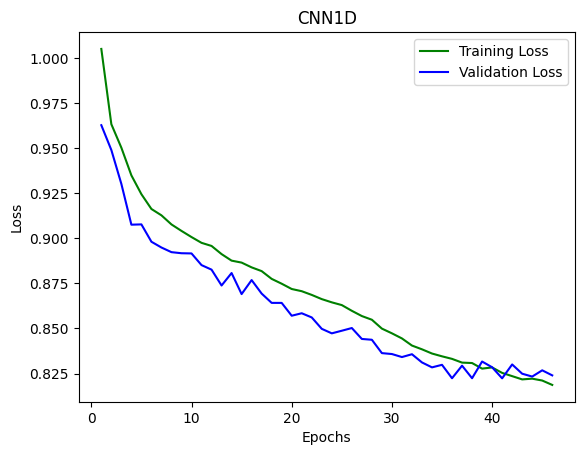

In [108]:
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('CNN1D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


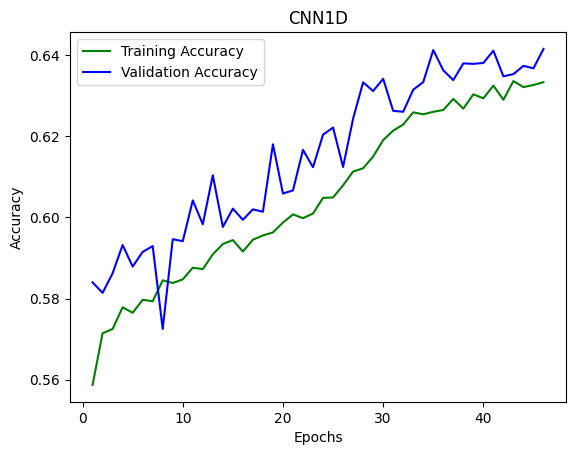

In [109]:
epochs = range(1, len(train_acc) + 1)  # This adjusts the range to match your data length
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('CNN1D')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [110]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

557/557 [==============================] - 4s 7ms/step


In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nTesting Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred_classes)*100))

print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_classes, average='weighted')*100))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_classes, average='weighted')*100))
print('F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred_classes, average='weighted')*100))
print('F1-score-m: {:.2f}\n'.format(f1_score(y_test, y_pred_classes, average='macro')*100))


Testing Accuracy: 63.62

Precision: 97.89
Recall: 63.62
F1-score: 76.20

F1-score-m: 42.21



In [112]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[11080  6420]
 [   55   245]]
